In [1]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [8]:
test_folder = "test_pano_2ss/34.27104358572289,-118.4859621549164/raw"

def batch_inference(images, image_numbers):
    # Process batch of images
    inputs = feature_extractor(images=images, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

    pred_converted_masks = []
    for i, image in enumerate(images):
        # Predicted semantic segmentation
        upsampled_logits = torch.nn.functional.interpolate(
            logits[i:i+1],
            size=image.size[::-1], # (height, width)
            mode='bilinear',
            align_corners=False
        )
        pred_seg = upsampled_logits.argmax(dim=1)[0]


        # Convert 9->2 and 8->1, all else becomes 0
        pred_converted_mask = np.zeros_like(pred_seg)
        pred_converted_mask[pred_seg == 9] = 1
        pred_converted_mask[pred_seg == 8] = 2
        
        pred_converted_masks.append(pred_converted_mask)

    return pred_converted_masks, pred_seg

def process_image(image_path):
    # Process a single image
    image = Image.open(image_path).resize((1080, 1080))
    image = image.convert('RGB')
    image_number = os.path.basename(image_path)[:-5]  # Extract number from imgX.jpeg
    return image, image_number

def process_folder():
    # Get list of all image files in test_folder
    image_files = [f for f in os.listdir(test_folder) if f.startswith('image') and f.endswith('.jpeg')]
    
    image_files = image_files[0:2]

    # Process all images at once
    batch_images = []
    batch_numbers = []
    
    for image_file in image_files:
        image_path = os.path.join(test_folder, image_file)
        image, image_number = process_image(image_path)
        batch_images.append(image)
        batch_numbers.append(image_number)
        
    pred_masks, pred_masks_all = batch_inference(batch_images, batch_numbers)

    return batch_numbers, batch_images, pred_masks, pred_masks_all



batch_panoids, batch_images, pred_masks, pred_masks_all = process_folder()


In [14]:
# Calculate percentage of each class (0, 1, 2) for each mask
for i, mask in enumerate(pred_masks):
    total_pixels = mask.size
    zeros = np.sum(mask == 0) / total_pixels * 100
    ones = np.sum(mask == 1) / total_pixels * 100  
    twos = np.sum(mask == 2) / total_pixels * 100
    
    print(f"\nImage {batch_panoids[i]}:")
    print(f"Class 0 (Background): {zeros:.2f}%")
    print(f"Class 1 (Terrain): {ones:.2f}%") 
    print(f"Class 2 (Tree): {twos:.2f}%")



Image image_-oL8dMG0LkCwZaRmo4tuPg:
Class 0 (Background): 89.65%
Class 1 (Terrain): 5.16%
Class 2 (Tree): 5.19%

Image image_zwkpBx2s6jEvoVlbFNZFjw:
Class 0 (Background): 92.36%
Class 1 (Terrain): 1.93%
Class 2 (Tree): 5.71%


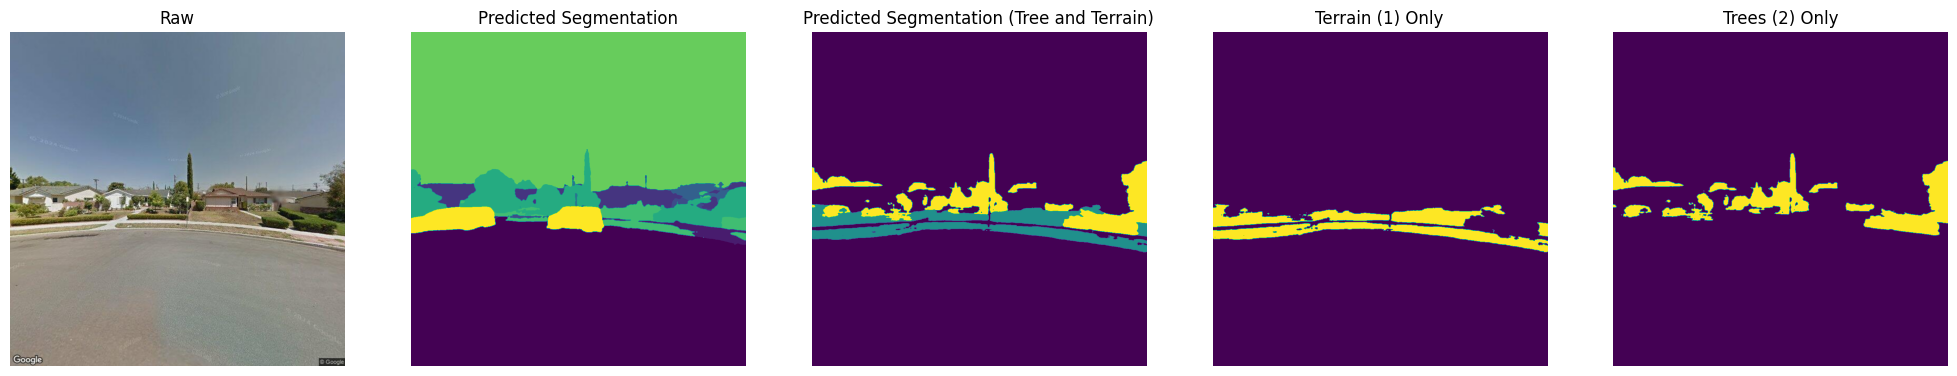

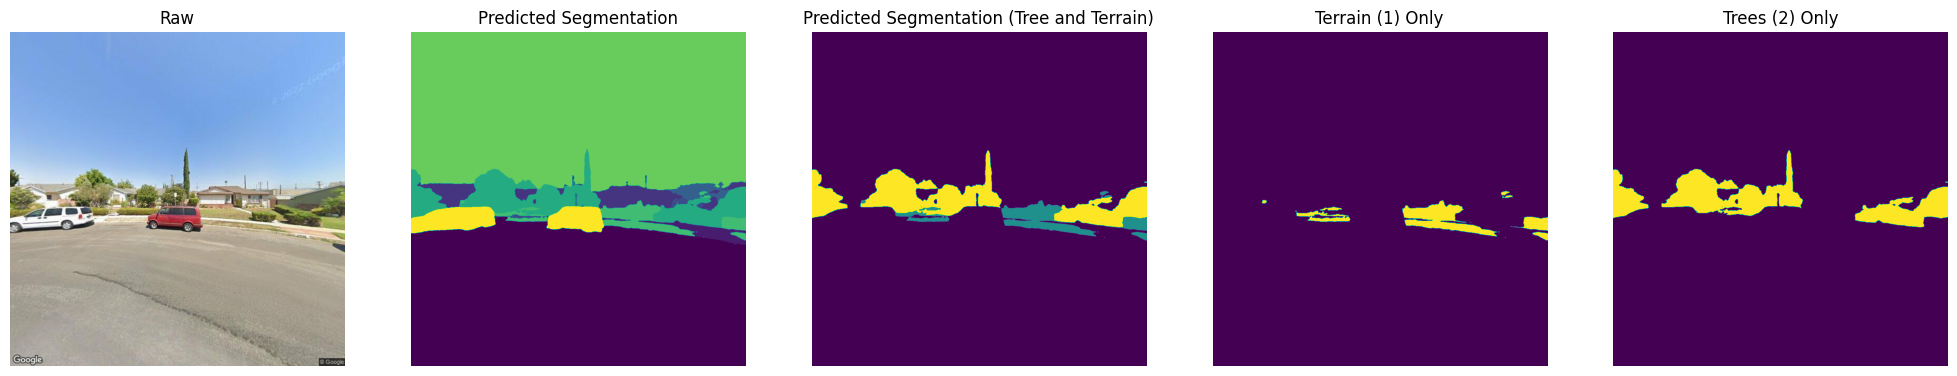

In [18]:
# Display original images, predictions and ground truth
for i in range(len(batch_images)):
    plt.figure(figsize=(25,5))
    
    plt.subplot(1,5,1)
    plt.imshow(batch_images[i])
    plt.title('Raw')
    plt.axis('off')

    plt.subplot(1,5,2)
    plt.imshow(pred_masks_all.cpu().numpy())
    plt.title('Predicted Segmentation')
    plt.axis('off')

    plt.subplot(1,5,3)
    plt.imshow(pred_masks[i])
    plt.title('Predicted Segmentation (Tree and Terrain)')
    plt.axis('off')

    # Plot label 1 (Trees) and label 2 (Terrain) separately
    plt.subplot(1,5,4)
    trees_only = np.zeros_like(pred_masks[i])
    trees_only[pred_masks[i] == 1] = 1 
    plt.imshow(trees_only)
    plt.title('Terrain (1) Only')
    plt.axis('off')

    plt.subplot(1,5,5)
    terrain_only = np.zeros_like(pred_masks[i])
    terrain_only[pred_masks[i] == 2] = 1 
    plt.imshow(terrain_only)
    plt.title('Trees (2) Only')
    plt.axis('off')